 $$ RMSLE = \sum_{i=1}^{n} \sqrt{\frac{1}{n} \big{(} log(p_i+1) - log(y_i+1) \big{)}^{2} } $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from razdel import tokenize 
import pymorphy2
from scipy.sparse import csc_matrix, vstack, hstack
import xgboost as xgb
import datetime


%matplotlib inline

In [44]:
data_train = pd.read_csv('train.csv', sep=',', parse_dates=['start_time']) #nrows=1000)

In [3]:
data_train.head()

,id,start_time,title,price,item_id,owner_type,category,subcategory,param1,param2,param3,region,item_views
0,328853,2016-12-27 10:38:04,Сандали фирмы Crocs,800,1301822498390501359,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва,3.332205
1,257639,2016-12-27 15:23:55,Бутсы футбольные Reebok,2000,4439620035274845039,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Омская область,2.302585
2,140732,2016-12-28 19:34:15,Nike hypervenom Бутсы,600,4860577743813309218,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Санкт-Петербург,4.663439
3,3080,2016-12-26 10:26:02,Сапоги,150,3492530336858889466,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Тульская область,3.367296
4,325394,2016-12-26 17:09:19,Кеды 38,500,3559049054931858928,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Самарская область,2.302585


In [4]:
data_train.describe()

,id,price,item_id,item_views
count,376687.000000,3.766870e+05,3.766870e+05,376687.000000
mean,211784.700144,2.465498e+05,4.606439e+18,3.483459
std,122355.459807,1.126163e+07,2.663233e+18,1.019757
min,0.000000,0.000000e+00,6.694595e+13,0.000000
25%,105786.500000,5.000000e+02,2.296781e+18,2.708050
50%,211758.000000,2.000000e+03,4.606254e+18,3.367296
75%,317745.500000,9.990000e+03,6.912617e+18,4.094345
max,423771.000000,5.677568e+09,9.223325e+18,8.328693


In [5]:
# есть ли пропуски
print(np.any(data_train.isna()))
data_train = data_train.fillna('nan')
print(np.any(data_train.isna()))

True
False


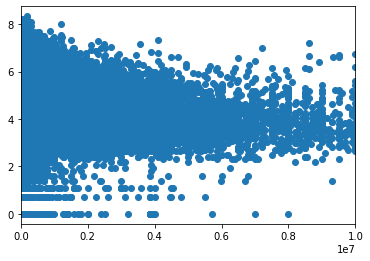

In [6]:
# распределение просмотров от цены

plt.scatter(data_train.price, data_train.item_views)
plt.xlim([-10000, 10000000]);

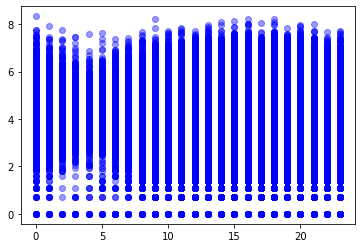

In [7]:
# распределение просмотров от времени выкладывания

plt.plot( data_train.start_time.apply(lambda x: x.hour), data_train.item_views, 
         'ob',  alpha=0.4)

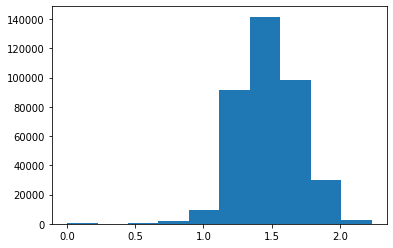

In [8]:
# гистограмму просмотров
plt.hist( np.log(data_train.item_views + 1) );

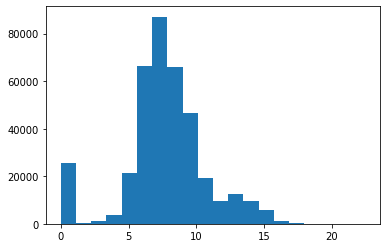

In [9]:
# гистограмму цены

plt.hist(np.log(data_train.price + 1), bins=20);

In [45]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376687 entries, 0 to 376686
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           376687 non-null  int64         
 1   start_time   376687 non-null  datetime64[ns]
 2   title        376687 non-null  object        
 3   price        376687 non-null  int64         
 4   item_id      376687 non-null  int64         
 5   owner_type   376687 non-null  object        
 6   category     376687 non-null  object        
 7   subcategory  376687 non-null  object        
 8   param1       361456 non-null  object        
 9   param2       196112 non-null  object        
 10  param3       147746 non-null  object        
 11  region       376687 non-null  object        
 12  item_views   376687 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 37.4+ MB


### Рассмотрим признаки и возможные их обработки

In [11]:
data_train['owner_type'].unique()

# с этим признаком будем использовать get_dummies

array(['Private', 'Company', 'Shop'], dtype=object)

In [12]:
data_train['category'].unique()

# с этим признаком будем использовать get_dummies

array(['Личные вещи', 'Транспорт', 'Животные', 'Работа',
       'Бытовая электроника', 'Недвижимость', 'Услуги', 'Для дома и дачи',
       'Хобби и отдых', 'Для бизнеса'], dtype=object)

In [13]:
data_train['subcategory'].unique()[:10]

# отправим в мешок слов

array(['Детская одежда и обувь', 'Автомобили', 'Кошки', 'Резюме',
       'Собаки', 'Фототехника', 'Вакансии', 'Запчасти и аксессуары',
       'Одежда, обувь, аксессуары', 'Аудио и видео'], dtype=object)

In [14]:
data_train['param1'].unique()[:10]

# отправим в мешок слов

array(['Для мальчиков', 'С пробегом', 'Японский бобтейл', 'Строительство',
       'Той-терьер', 'Компактные фотоаппараты', 'Без опыта, студенты',
       'Шины, диски и колёса', 'Мужская одежда', 'Аксессуары'],
      dtype=object)

In [15]:
data_train['param2'].unique()[:10]

# отправим в мешок слов

array(['Обувь', 'Toyota', 'nan', 'Dodge', 'Cadillac', 'MG', 'Tata',
       'Сменный график', 'Chevrolet', 'Volkswagen'], dtype=object)

In [16]:
data_train['param3'].unique()[:10]

# отправим в мешок слов

array(['> 36', 'Soarer', 'nan', 'Challenger', 'SRX', 'ZS', 'Estate',
       'Avalanche', 'Touareg', '32'], dtype=object)

In [17]:
data_train['title'].unique()[:10]

# отправим в мешок слов

array(['Сандали фирмы Crocs', 'Бутсы футбольные Reebok',
       'Nike hypervenom Бутсы', 'Сапоги', 'Кеды 38',
       'Обувь для мини футбола', 'Бутсы для футбола Nike Mercurial',
       'Ботинки Timberland (38.5p) Идеальное состояние',
       'Ugg Australia р.38 унисекс', 'Подростковые зимние ботинки'],
      dtype=object)

In [18]:
data_train['region'].unique()[:10]

# закодируем по количеству

array(['Москва', 'Омская область', 'Санкт-Петербург', 'Тульская область',
       'Самарская область', 'Ханты-Мансийский АО',
       'Волгоградская область', 'Свердловская область',
       'Амурская область', 'Московская область'], dtype=object)

### Начнем с образования текста для мешка слов

In [19]:
# загружаем стоп слова

morph = pymorphy2.MorphAnalyzer()

stopword_rus = []

with open('stop_words_russian.txt', encoding="utf-8") as f:
    stopword_rus += [w.strip() for w in f.readlines() if w]
    
len(stopword_rus)

421

In [20]:
#для нормализации текста

@lru_cache(maxsize=100000) # с кешом!
def get_normal_form (i):
    return morph.normal_forms(i)[0]

def normalize_text(x):
    x = x[:200] 
    return ' '.join([get_normal_form(i) for i in re.findall('\w+', x)])

In [21]:
# для очистки текста

def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("\|", ' ', str(text))
    text = re.sub("https?:\/\/\S+", '', str(text))
    text = re.sub("[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

# для лематизации текста

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_rus]
    words_lem_without_stopwords_str = " ".join(words_lem_without_stopwords)
    
    return words_lem_without_stopwords_str

In [22]:
# образовываем полный текст описания объявления

data_train['full_text'] = data_train.param1 + ' ' + data_train.param2 + ' ' + data_train.param3 + ' ' +  data_train.subcategory + ' ' + data_train.title
data_train = data_train.drop(['param1', 'param2', 'param3', 'subcategory', 'title'], axis=1)
data_train.head(4)

,id,start_time,price,item_id,owner_type,category,region,item_views,full_text
0,328853,2016-12-27 10:38:04,800,1301822498390501359,Private,Личные вещи,Москва,3.332205,Для мальчиков Обувь > 36 Детская одежда и обув...
1,257639,2016-12-27 15:23:55,2000,4439620035274845039,Private,Личные вещи,Омская область,2.302585,Для мальчиков Обувь > 36 Детская одежда и обув...
2,140732,2016-12-28 19:34:15,600,4860577743813309218,Private,Личные вещи,Санкт-Петербург,4.663439,Для мальчиков Обувь > 36 Детская одежда и обув...
3,3080,2016-12-26 10:26:02,150,3492530336858889466,Private,Личные вещи,Тульская область,3.367296,Для мальчиков Обувь > 36 Детская одежда и обув...


In [24]:
# обрабатываем описание
%%time

data_train['full_text'] = data_train['full_text'].apply(lambda x: normalize_text(x))
data_train['full_text'] = data_train['full_text'].apply(lambda x: clean_text(x))
data_train['full_text'] = data_train['full_text'].apply(lambda x: lemmatization(x))
data_train.head(4)

UsageError: Line magic function `%%time` not found.


### Категории и тип объявления (get_dummies)

In [25]:
data_train = pd.get_dummies(data=data_train, columns=['owner_type', 'category'])
data_train.head(4)

,id,start_time,price,item_id,region,item_views,full_text,owner_type_Company,owner_type_Private,owner_type_Shop,category_Бытовая электроника,category_Для бизнеса,category_Для дома и дачи,category_Животные,category_Личные вещи,category_Недвижимость,category_Работа,category_Транспорт,category_Услуги,category_Хобби и отдых
0,328853,2016-12-27 10:38:04,800,1301822498390501359,Москва,3.332205,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,0,0,1,0,0,0,0,0
1,257639,2016-12-27 15:23:55,2000,4439620035274845039,Омская область,2.302585,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,0,0,1,0,0,0,0,0
2,140732,2016-12-28 19:34:15,600,4860577743813309218,Санкт-Петербург,4.663439,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,0,0,1,0,0,0,0,0
3,3080,2016-12-26 10:26:02,150,3492530336858889466,Тульская область,3.367296,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,0,0,1,0,0,0,0,0


### Обработка времени

In [26]:
# предобработка
# - время.

data_train.start_time = pd.to_datetime(data_train.start_time)

In [27]:
f = lambda x: (x.hour * 60 + x.minute) / (24 * 60)
data_train['relative_time'] = data_train.start_time.apply(f)

In [28]:
data_train['slided_hours'] = data_train.start_time.apply(lambda x: ((x.hour - 3.5) % 24) * 1. / 24.)

In [29]:
def make_harmonic_features(value, period=24):
    value = (value / period) * 2 * np.pi
    return np.cos(value), np.sin(value)

In [30]:
data_train['cos_time'] = data_train.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])
data_train['sin_time'] = data_train.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[1])

In [31]:
data_train['week_day'] = data_train.start_time.apply(lambda x: x.isoweekday())

In [32]:
data_train.head()

,id,start_time,price,item_id,region,item_views,full_text,owner_type_Company,owner_type_Private,owner_type_Shop,...,category_Недвижимость,category_Работа,category_Транспорт,category_Услуги,category_Хобби и отдых,relative_time,slided_hours,cos_time,sin_time,week_day
0,328853,2016-12-27 10:38:04,800,1301822498390501359,Москва,3.332205,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,...,0,0,0,0,0,0.443056,0.270833,-0.936672,0.350207,2
1,257639,2016-12-27 15:23:55,2000,4439620035274845039,Омская область,2.302585,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,...,0,0,0,0,0,0.640972,0.479167,-0.632705,-0.774393,2
2,140732,2016-12-28 19:34:15,600,4860577743813309218,Санкт-Петербург,4.663439,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,...,0,0,0,0,0,0.815278,0.645833,0.398749,-0.917060,3
3,3080,2016-12-26 10:26:02,150,3492530336858889466,Тульская область,3.367296,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,...,0,0,0,0,0,0.434722,0.270833,-0.917060,0.398749,1
4,325394,2016-12-26 17:09:19,500,3559049054931858928,Самарская область,2.302585,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,...,0,0,0,0,0,0.714583,0.562500,-0.220697,-0.975342,1


In [33]:
data_train = data_train.drop(['start_time'], axis=1)

# Регион

In [34]:
def _counter_encoder(dt, str_cols, counter_Encoders, is_train=True):
    """
    Counter Encoder.
    """
    if is_train:
        counter_Encoders = {col:dt[col].value_counts().to_dict() for col in str_cols}
    for column in str_cols:
        dt[column+'_enc_by_count'] = dt[column].apply(lambda x: counter_Encoders[column].get(x, 0)) 
    return counter_Encoders

In [35]:
counter_Encoders = _counter_encoder(data_train, str_cols=['region'], counter_Encoders=None, is_train=True)

In [36]:
data_train = data_train.drop(['region'], axis=1)
data_train.head(4)

,id,price,item_id,item_views,full_text,owner_type_Company,owner_type_Private,owner_type_Shop,category_Бытовая электроника,category_Для бизнеса,...,category_Работа,category_Транспорт,category_Услуги,category_Хобби и отдых,relative_time,slided_hours,cos_time,sin_time,week_day,region_enc_by_count
0,328853,800,1301822498390501359,3.332205,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,...,0,0,0,0,0.443056,0.270833,-0.936672,0.350207,2,70683
1,257639,2000,4439620035274845039,2.302585,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,...,0,0,0,0,0.640972,0.479167,-0.632705,-0.774393,2,4265
2,140732,600,4860577743813309218,4.663439,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,...,0,0,0,0,0.815278,0.645833,0.398749,-0.917060,3,36663
3,3080,150,3492530336858889466,3.367296,Для мальчиков Обувь > 36 Детская одежда и обув...,0,1,0,0,0,...,0,0,0,0,0.434722,0.270833,-0.917060,0.398749,1,2986


### Убираем лишнее 

In [37]:
data_train = data_train.drop(['id', 'item_id'], axis=1)

### Разбиваем выборку

In [38]:
X, y = data_train.drop(['item_views'], axis=1), data_train['item_views'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### TfidfVectorizer

In [39]:
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(X_train['full_text'])
tfidf_test = vectorizer.transform(X_test['full_text'])

In [40]:
X_train = X_train.drop(['full_text'], axis=1)
X_test = X_test.drop(['full_text'], axis=1)

### Объединение матриц

In [41]:
data_tr_val = csc_matrix(X_train.values)
data_ts_val = csc_matrix(X_test.values)

X_train = csc_matrix(hstack([data_tr_val, tfidf_train]))
X_test = csc_matrix(hstack([data_ts_val, tfidf_test]))

### Обучение модели

In [42]:
xgb_params = {
    'objective': 'reg:linear',
    'max_depth': 15,
    'eta': 0.1,
    'gamma' : 0,
    'booster': 'gbtree',
    
    'alpha': 2.0,
    'lambda': 0.1,
    
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 1.0,
    
    'min_child_weight': 1,
    'silent': 1,
    'seed': 1,
    'nthread': 4,
    'eval_metric':'rmse'
}

num_rounds = 200

start = datetime.datetime.now()

dtrain = xgb.DMatrix( X_train, label=np.log(y_train+1)) 
dtest = xgb.DMatrix( X_test, label=np.log(y_test+1)) 

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
eval_res ={}
gbdt = xgb.train(xgb_params, dtrain,
                 num_rounds, watchlist,
                 early_stopping_rounds=500,
                 verbose_eval=10,
                 evals_result=eval_res)

print (datetime.datetime.now() - start)

[15:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.90397	eval-rmse:0.90391
[10]	train-rmse:0.34611	eval-rmse:0.34811
[20]	train-rmse:0.18161	eval-rmse:0.18897
[30]	train-rmse:0.14551	eval-rmse:0.15706
[40]	train-rmse:0.13779	eval-rmse:0.15134
[50]	train-rmse:0.13610	eval-rmse:0.15028
[60]	train-rmse:0.13525	eval-rmse:0.14979
[70]	train-rmse:0.13431	eval-rmse:0.14934
[80]	train-rmse:0.13358	eval-rmse:0.14894
[90]	train-rmse:0.13274	eval-rmse:0.14849
[100]	train-rmse:0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

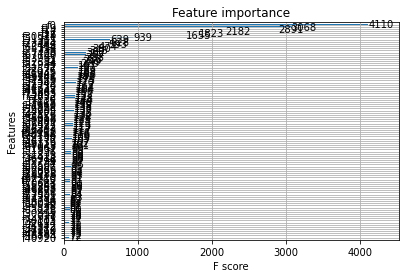

In [43]:
xgb.plot_importance(gbdt, max_num_features=100)